In [1]:
!pip install --upgrade dagshub mlflow imbalanced-learn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 57.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 94.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 6.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 58.4 MB/s eta 0:00:0000:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [3]:
df_train_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
df_train_tr = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')

In [4]:
df = pd.merge(df_train_tr, df_train_id, on='TransactionID', how='left')

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['isFraud'])
y = df['isFraud']

# Get unique card1 values
unique_card1s = df['card1'].unique()

# Split card1 values into train/val/test
card1_train, card1_temp = train_test_split(unique_card1s, test_size=0.4, random_state=42)
card1_val, card1_test = train_test_split(card1_temp, test_size=0.5, random_state=42)

# Filter dataframe
X_transaction_train_df = X[df['card1'].isin(card1_train)].copy()
y_transaction_train_df = y[df['card1'].isin(card1_train)].copy()

X_transaction_val_df = X[df['card1'].isin(card1_val)].copy()
y_transaction_val_df = y[df['card1'].isin(card1_val)].copy()

X_transaction_test_df = X[df['card1'].isin(card1_test)].copy()
y_transaction_test_df = y[df['card1'].isin(card1_test)].copy()

In [6]:
categorical_columns = [col for col in X_transaction_train_df.columns if X_transaction_train_df[col].dtype == 'object']
numerical_columns = [col for col in X_transaction_train_df.columns if X_transaction_train_df[col].dtype != 'object']

In [7]:
len(categorical_columns) + len(numerical_columns) == len(X_transaction_train_df.columns)

True

In [8]:
high_nan_cols = X_transaction_train_df.columns[X_transaction_train_df.isna().mean() > 0.85]
all_nan_columns = X_transaction_train_df.columns[X_transaction_train_df.isna().mean() != 0]

print(f'{len(high_nan_cols)}: {high_nan_cols}')

74: Index(['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139',
       'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148',
       'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157',
       'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166',
       'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330',
       'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339',
       'id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10', 'id_14', 'id_18',
       'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30',
       'id_32', 'id_33', 'id_34'],
      dtype='object')


In [9]:
X_corr_trans = X_transaction_train_df[numerical_columns].copy()
X_corr_trans['isFraud'] = y_transaction_train_df

In [10]:
%%time

corr_matrix = X_corr_trans.corr().abs()

CPU times: user 2min 10s, sys: 238 ms, total: 2min 10s
Wall time: 2min 11s


In [11]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Find feature pairs with correlation greater than a threshold
threshold = 0.95
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Display highly correlated pairs
if high_corr_pairs:
    print("Highly correlated feature pairs:")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"{feat1} and {feat2}: {corr:.4f}")
else:
    print(f"No feature pairs with correlation above {threshold} found.")

# To remove one feature from each highly correlated pair
# (typically the one with lower correlation with target)
features_to_drop = []
for feat1, feat2, _ in high_corr_pairs:
    # Compare correlation with target
    if abs(X_corr_trans[feat1].corr(y)) < abs(X_corr_trans[feat2].corr(y)):
        features_to_drop.append(feat1)
    else:
        features_to_drop.append(feat2)

# Remove duplicates
features_to_drop = list(set(features_to_drop))
print(f"Features to drop due to high correlation: {features_to_drop}")

Highly correlated feature pairs:
TransactionID and TransactionDT: 0.9983
C1 and C2: 0.9947
C1 and C4: 0.9654
C1 and C6: 0.9808
C1 and C8: 0.9651
C1 and C10: 0.9547
C1 and C11: 0.9964
C2 and C4: 0.9697
C2 and C6: 0.9726
C2 and C8: 0.9737
C2 and C10: 0.9680
C2 and C11: 0.9933
C4 and C6: 0.9600
C4 and C8: 0.9549
C4 and C11: 0.9726
C6 and C11: 0.9904
C6 and C14: 0.9838
C7 and C8: 0.9805
C7 and C10: 0.9827
C7 and C12: 0.9995
C8 and C10: 0.9966
C8 and C11: 0.9590
C8 and C12: 0.9806
C10 and C11: 0.9515
C10 and C12: 0.9816
C11 and C14: 0.9613
D1 and D2: 0.9820
D4 and D6: 0.9548
D4 and D12: 1.0000
D5 and D7: 0.9860
D6 and D12: 0.9732
V10 and V11: 0.9663
V15 and V16: 0.9865
V15 and V33: 0.9579
V15 and V57: 0.9591
V15 and V94: 0.9526
V17 and V18: 0.9899
V17 and V21: 0.9571
V21 and V22: 0.9515
V21 and V84: 0.9556
V27 and V28: 0.9693
V28 and V68: 0.9711
V28 and V89: 0.9682
V29 and V30: 0.9561
V31 and V32: 0.9862
V31 and V50: 0.9808
V31 and V71: 0.9592
V31 and V92: 0.9640
V32 and V50: 0.9587
V33 and

In [12]:
len(features_to_drop)

143

In [13]:
columns_to_delete = ['TransactionID']
columns_to_delete.extend(features_to_drop)

len(columns_to_delete)

144

# Preprocessor

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, numerical_columns, del_cols):
        self.categorical_columns = categorical_columns
        self.numerical_columns = numerical_columns
        self.del_cols = del_cols

    def fit(self, X, y):
        self.woe_columns = self.categorical_columns
        
        df_woe = X.copy()
        target_col = 'isFraud'
        df_woe[target_col] = y

        woe_mappings = {}
        iv_values = {}
        
        for col in self.woe_columns:
            if col in self.del_cols:
                continue
            groups = df_woe.groupby([col])[target_col].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
            
            groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
            groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()
            
            groups['woe'] = np.log(groups['prop_pos'] / groups['prop_neg'])
            groups['iv'] = (groups['prop_pos'] - groups['prop_neg']) * groups['woe']
            
            groups.replace([np.inf, -np.inf], 0, inplace=True)
            groups.fillna(0, inplace=True)
            
            woe_dict = groups['woe'].to_dict()
            iv = groups['iv'].sum()
            
            woe_mappings[col] = woe_dict
            iv_values[col] = iv

        self.woe_mappings = woe_mappings
        self.iv_values = iv_values

        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        X_transformed = X_transformed.fillna(value={col: 0 for col in self.numerical_columns})

        woe_encoded_cols = {}
        for col in self.woe_columns:
            if col in self.del_cols:
                continue
            # X_transformed[f'{col}_woe'] = X_transformed[col].map(self.woe_mappings[col])
            woe_encoded_cols[f'{col}_woe'] = X_transformed[col].map(self.woe_mappings[col]).fillna(0)
            X_transformed.drop(columns=col, inplace=True)

        X_transformed = pd.concat([X_transformed, pd.DataFrame(woe_encoded_cols, index=X_transformed.index)], axis=1)
        X_transformed = X_transformed.drop(columns = self.del_cols)

        assert not X_transformed.isna().any().any()

        return X_transformed
        

# Pipeline (Imbalanced Learn)

In [ ]:
# import shap

# model = RandomForestClassifier(max_depth=20, min_samples_split=20, min_samples_leaf=100, n_jobs=20, max_leaf_nodes=100)

# %%time
# # booster = model.get_booster()
# explainer = shap.TreeExplainer(model)

# shap_values = explainer.shap_values(X_transaction_train_df)

In [15]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

model = XGBClassifier()
# model = LogisticRegression(max_iter=1000)
# model = RandomForestClassifier(max_depth=20, min_samples_split=20, min_samples_leaf=100, n_jobs=20, max_leaf_nodes=100)
preprocessor = Preprocessor(categorical_columns, numerical_columns, columns_to_delete)

sampler = RandomUnderSampler(random_state=42, sampling_strategy=0.2)
scaler = StandardScaler()
# Imbalanced-learn pipeline
pipeline = ImbPipeline(steps=[
    ('undersampler', sampler),  # Undersampling step
    ('preprocess', preprocessor),
    ('scaler', StandardScaler()),
    ('model', model)
])

pipeline.fit(X_transaction_train_df, y_transaction_train_df)


Pipeline(steps=[('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.2)),
                ('preprocess',
                 Preprocessor(categorical_columns=['ProductCD', 'card4',
                                                   'card6', 'P_emaildomain',
                                                   'R_emaildomain', 'M1', 'M2',
                                                   'M3', 'M4', 'M5', 'M6', 'M7',
                                                   'M8', 'M9', 'id_12', 'id_15',
                                                   'id_16', 'id_23', 'id_27',
                                                   'id_28', 'id_29', 'id_30',
                                                   'id_31', 'id_33', 'id_34',
                                                   'id_35', 'id_36', 'i...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [16]:
# X_res, y_res = sampler.fit_resample(X_transaction_train_df, y_transaction_train_df)

# preprocessor.fit(X_res, y_res)
# X_res_trans = preprocessor.transform(X_res)

# X_res_trans = scaler.fit_transform(X_res_trans)

# model.fit(X_res_trans, y_res)

In [17]:
preds_train = pipeline.predict_proba(X_transaction_train_df)[:, 1]
preds_val = pipeline.predict_proba(X_transaction_val_df)[:, 1]
preds_test = pipeline.predict_proba(X_transaction_test_df)[:, 1]

# Assumption

### draw one estimator 

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Access the fitted XGBoost model
xgb_model = pipeline.named_steps['model']

# Plot the first tree (tree_index=0)
plt.figure(figsize=(20, 10))
plot_tree(xgb_model, num_trees=0)
plt.show()

### Calculate AUC score

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

def plot_roc_and_get_metrics(y_true, y_pred_proba, threshold=0.5, title='ROC Curve & Metrics', save_path=None):
    """
    Plots ROC curve, saves it (optional), prints and returns classification metrics.

    Parameters:
    - y_true: array-like — True binary labels
    - y_pred_proba: array-like — Predicted probabilities for positive class
    - threshold: float — Threshold for binary classification
    - title: str — Plot title
    - save_path: str — If provided, saves ROC curve to this file path

    Returns:
    - dict of metrics
    """
    y_pred = (y_pred_proba >= threshold).astype(int)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    metrics = {
        "accuracy": round(accuracy_score(y_true, y_pred), 4),
        "precision": round(precision_score(y_true, y_pred), 4),
        "recall": round(recall_score(y_true, y_pred), 4),
        "specificity": round(specificity, 4),
        "f1_score": round(f1_score(y_true, y_pred), 4),
        "auc": round(roc_auc, 4)
    }

    for k, v in metrics.items():
        print(f"{k.capitalize():<12}: {v}")

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid()

    if save_path:
        plt.savefig(save_path)
    plt.show()

    return metrics


Accuracy    : 0.9785
Precision   : 0.6778
Recall      : 0.7395
Specificity : 0.9872
F1_score    : 0.7073
Auc         : 0.9662


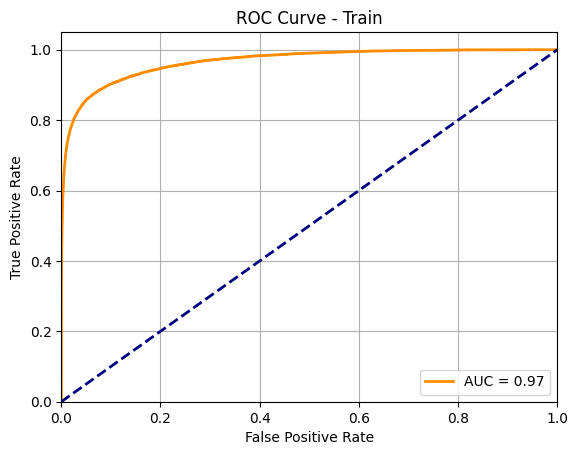

Accuracy    : 0.9631
Precision   : 0.5256
Recall      : 0.5349
Specificity : 0.9805
F1_score    : 0.5302
Auc         : 0.8892


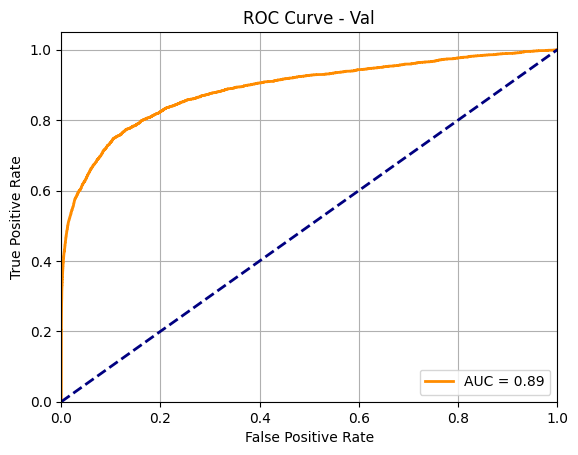

Accuracy    : 0.9671
Precision   : 0.4656
Recall      : 0.3612
Specificity : 0.9866
F1_score    : 0.4068
Auc         : 0.8283


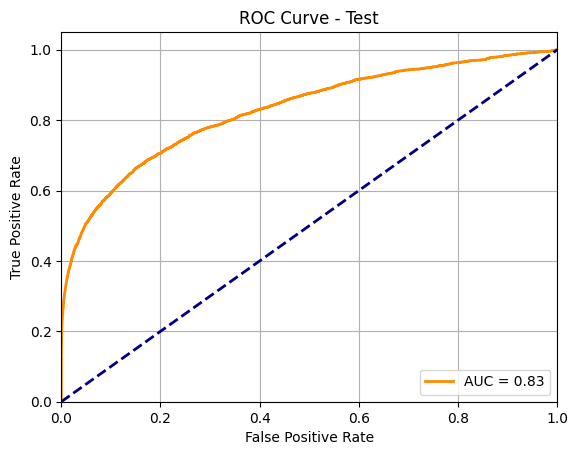

In [20]:
plot_roc_and_get_metrics(y_transaction_train_df, preds_train, title='ROC Curve - Train')
plot_roc_and_get_metrics(y_transaction_val_df, preds_val, title='ROC Curve - Val')
metrics_for_test_set = plot_roc_and_get_metrics(y_transaction_test_df, preds_test, title='ROC Curve - Test')

# Save On MLflow

In [ ]:
import dagshub
dagshub.init(repo_owner='nmach22', repo_name='Fraud-Detection-ml', mlflow=True)

In [ ]:
import mlflow 
from mlflow.models.signature import infer_signature

model_name = type(model).__name__
model_params = model.get_params()

sampler_name = type(sampler).__name__
sampler_params = sampler.get_params()


experiment_name = model_name + '_Pipeline'
run_name = 'fill nans with 0, woe encoding, remove high corellated columns, with RandomUnderSampler (identity.csv joind)'

rf_model = pipeline.named_steps['model']
tree = rf_model.estimators_[0]  # Pick first tree

roc_plot_train_path = "roc_curve_train.png"
metrics_for_train_set = plot_roc_and_get_metrics(
    y_transaction_train_df, 
    preds_train, 
    title='ROC Curve - Train',
    save_path=roc_plot_train_path
)

roc_plot_validation_path = "roc_curve_validation.png"
metrics_for_validation_set = plot_roc_and_get_metrics(
    y_transaction_val_df, 
    preds_val, 
    title='ROC Curve - Validation',
    save_path=roc_plot_validation_path
)

roc_plot_test_path = "roc_curve_test.png"
metrics_for_test_set = plot_roc_and_get_metrics(
    y_transaction_test_df, 
    preds_test, 
    title='ROC Curve - Test',
    save_path=roc_plot_test_path
)

tree_plot_path = "random_forest_tree_plot.png"

plt.figure(figsize=(30, 15))
plot_tree(
    tree, 
    filled=True, 
    feature_names=X_transaction_train_df.columns, 
    class_names=['class0', 'class1'],
    rounded=True,
    proportion=True,
    fontsize=10
)
plt.savefig(tree_plot_path)
plt.close()

mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=run_name):
    # Log parameters
    mlflow.log_param("fillna_numerical_value", 0)
    mlflow.log_param("removed columns", columns_to_delete)
    
    mlflow.log_param("model_name", model_name)
    for param in model_params:
        mlflow.log_param(f'{model_name}_{param}' , model_params[param])
    
    mlflow.log_param("sampler_name", sampler_name)
    for param in sampler_params:
        mlflow.log_param(f'{sampler_name}_{param}', sampler_params[param])

    # Log metrics for train
    for metric_name, metric_value in metrics_for_train_set.items():
        mlflow.log_metric(f'train_{metric_name.capitalize()}', metric_value)
    
    # Log metrics for validation
    for metric_name, metric_value in metrics_for_validation_set.items():
        mlflow.log_metric(f'val_{metric_name.capitalize()}', metric_value)
    
    # Log metrics for test
    for metric_name, metric_value in metrics_for_test_set.items():
        mlflow.log_metric(f'test_{metric_name.capitalize()}', metric_value)

    input_example = X_transaction_train_df.head(1)
    signature = infer_signature(X_transaction_train_df, pipeline.predict_proba(X_transaction_train_df))
    
    # Log model
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="pipeline",
        input_example=input_example,
        signature=signature
    )

    # Log ROC plot as artifact
    mlflow.log_artifact(roc_plot_validation_path)
    mlflow.log_artifact(roc_plot_test_path)
    mlflow.log_artifact(roc_plot_train_path)
    mlflow.log_artifact(tree_plot_path)